In [1]:
import cv2
import numpy as np
#import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import os

In [2]:
#os.listdir()

In [3]:
"""START HERE"""
1,256,400
gauge_number = 1
file_type='jpg'
# name the calibration image of your gauge 'gauge-#.jpg', for example 'gauge-5.jpg'.  It's written this way so you can easily try multiple images
###min_angle, max_angle, min_value, max_value, units, x, y, r = calibrate_gauge(gauge_number, file_type)

#feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
img = cv2.imread('../Gauge/frames/frame%s.%s' % (gauge_number, file_type))
###val = get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type)
###print ("Current reading: %s %s" %(val, units))

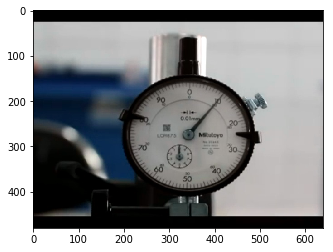

In [4]:
plt.imshow(img)

In [5]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [6]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [7]:
#def calibrate_gauge(gauge_number, file_type):
#gauge_number=5
#file_type='jpg'
'''
    This function should be run using a test image in order to calibrate the range available to the dial as well as the
    units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
    (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
    as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
    position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
    the gauge is linear (as most probably are).
    It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
    and the units (as a string).
'''

img = cv2.imread('../Gauge/frames/frame%s.%s' %(gauge_number, file_type))
height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
#gray = cv2.GaussianBlur(gray, (5, 5), 0)
#gray = cv2.medianBlur(gray, 5)

#for testing, output gray image
#cv2.imwrite('gauge-%s-bw.%s' %(gauge_number, file_type),gray)

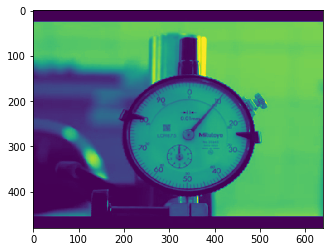

In [8]:
plt.imshow(gray)

In [9]:
#del circles
#detect circles
#restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
#these are pixel values which correspond to the possible radii search range.

#circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.48))

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 80)

# average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one

In [10]:
circles

array([[[344.5, 267.5, 127.9]]], dtype=float32)

In [11]:
#del a, b, c,x,y,r

a, b, c = circles.shape
x,y,r = avg_circles(circles, b)

#draw center and circle
cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

#for testing, output circles on image
#cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


#for calibration, plot lines from center going out at every 10 degrees and add marker
#for i from 0 to 36 (every 10 deg)

'''
goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
line.  These lines and text labels serve as the reference point for the user to enter
NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
(i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
'''
separation = 10.0 #in degrees
interval = int(360 / separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
text_offset_x = 10
text_offset_y = 5
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

cv2.imwrite('../Gauge/processed/frame%s-calibration.%s' % (gauge_number, file_type), img)

#get user input on min, max, values, and units
print ('gauge number: %s' %gauge_number)
"""min_angle = 50 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 320 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 200 #raw_input('Max value: ') #maximum reading of the gauge
units = 'PSI' #raw_input('Enter units: ')"""

#for testing purposes: hardcode and comment out raw_inputs above
# min_angle = 45
# max_angle = 320
# min_value = 0
# max_value = 200
# units = "PSI"

#return min_angle, max_angle, min_value, max_value, units, x, y, r

gauge number: 1


"min_angle = 50 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle\nmax_angle = 320 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle\nmin_value = 0 #raw_input('Min value: ') #usually zero\nmax_value = 200 #raw_input('Max value: ') #maximum reading of the gauge\nunits = 'PSI' #raw_input('Enter units: ')"

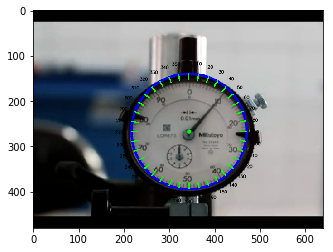

In [12]:
plt.imshow(img)

In [14]:
min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
units = 'mm' #raw_input('Enter units: ')

In [15]:
#def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type):

#for testing purposes
#img = cv2.imread('gauge-%s.%s' % (gauge_number, file_type))

gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Set threshold and maxValue
thresh = 175
maxValue = 255

# for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
# th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
# th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
# th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
# th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
# th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
# cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
# cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
# cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
# cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
# cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

# apply thresholding which helps for finding lines
(thresh, dst2) = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring


dst2 = cv2.medianBlur(dst2, 5)
dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)
dst2 = cv2.Canny(dst2, 50, 150)


"""_, contours, _ = cv2.findContours(dst2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv2.contourArea(c);
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue
    # Draw each contour only for visualisation purposes
    cv2.drawContours(dst2, contours, i, (0, 0, 255), 2);"""

# for testing, show image after thresholding
cv2.imwrite('../Gauge/processed/frame%s-tempdst1.%s' % (gauge_number, file_type), dst2)

# find lines


True

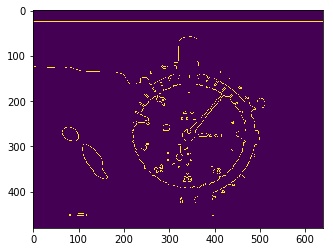

In [16]:
plt.imshow(dst2)

In [17]:
minLineLength = 10
maxLineGap = 0
lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

#for testing purposes, show all found lines
"""for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"""

"for i in range(0, len(lines)):\n    for x1, y1, x2, y2 in lines[i]:\n        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)\ncv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"

In [18]:
lines.shape

(10, 1, 4)

In [19]:
# remove all lines outside a given radius
final_line_list = []
#print "radius: %s" %r

diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
diff1UpperBound = 0.25
diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
diff2UpperBound = 1.0

print("length of lines %d"%len(lines))

for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
        diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
        #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
        if (diff1 > diff2):
            temp = diff1
            diff1 = diff2
            diff2 = temp
        # check if line is within an acceptable range
        #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
            line_length = dist_2_pts(x1, y1, x2, y2)
            # add to final list
            final_line_list.append([x1, y1, x2, y2])

#testing only, show all lines after filtering
# for i in range(0,len(final_line_list)):
#     x1 = final_line_list[i][0]
#     y1 = final_line_list[i][1]
#     x2 = final_line_list[i][2]
#     y2 = final_line_list[i][3]
#     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# assumes the first line is the best one
x1 = final_line_list[0][0]
y1 = final_line_list[0][1]
x2 = final_line_list[0][2]
y2 = final_line_list[0][3]
cv2.line(img, (x, y), (x2, y2), (0, 255, 0), 2)

#for testing purposes, show the line overlayed on the original image
#cv2.imwrite('gauge-1-test.jpg', img)
cv2.imwrite('../Gauge/processed/frame%s-lines-2.%s' % (gauge_number, file_type), img)

#find the farthest point from the center to be what is used to determine the angle
dist_pt_0 = dist_2_pts(x, y, x1, y1)
dist_pt_1 = dist_2_pts(x, y, x2, y2)
if (dist_pt_0 > dist_pt_1):
    x_angle = x1 - x
    y_angle = y - y1
else:
    x_angle = x2 - x
    y_angle = y - y2
# take the arc tan of y/x to find the angle
res = np.arctan(np.divide(float(y_angle), float(x_angle)))
#np.rad2deg(res) #coverts to degrees
print("angle is %d" % (res))
# print x_angle
# print y_angle
# print res
# print np.rad2deg(res)

#these were determined by trial and error
res = np.rad2deg(res)

print("degrees %d" % (res))

if x_angle > 0 and y_angle > 0:  #in quadrant I
    final_angle = 270 - res
if x_angle < 0 and y_angle > 0:  #in quadrant II
    final_angle = 90 - res
if x_angle < 0 and y_angle < 0:  #in quadrant III
    final_angle = 90 - res
if x_angle > 0 and y_angle < 0:  #in quadrant IV
    final_angle = 270 - res

#print final_angle

old_min = float(min_angle)
old_max = float(max_angle)

new_min = float(min_value)
new_max = float(max_value)

old_value = final_angle

old_range = (old_max - old_min)
new_range = (new_max - new_min)
new_value = (((old_value - old_min) * new_range) / old_range) + new_min

print(new_value)
#return new_value

length of lines 10
angle is 0
degrees -35
34.50548226762122


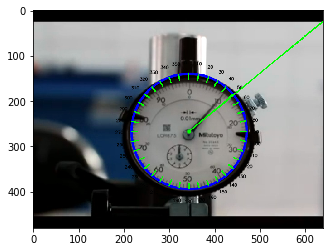

In [19]:
plt.imshow(img)

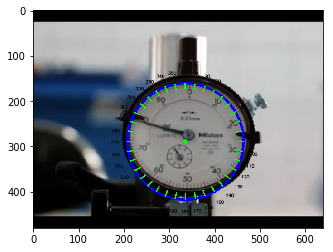

In [20]:
plt.imshow(img)

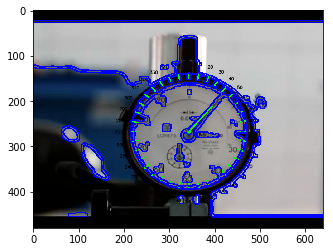

In [23]:
plt.imshow(img)

In [22]:
import cv2
import numpy as np
#import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import os

In [23]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [24]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [25]:
def calibrate_gauge(gauge_number, file_type):
    '''
        This function should be run using a test image in order to calibrate the range available to the dial as well as the
        units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
        (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
        as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
        position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
        the gauge is linear (as most probably are).
        It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
        and the units (as a string).
    '''

    img = cv2.imread('../Gauge/frames/frame%s.%s' %(gauge_number, file_type))
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # gray = cv2.medianBlur(gray, 5)

    #for testing, output gray image
    #cv2.imwrite('gauge-%s-bw.%s' %(gauge_number, file_type),gray)

    #detect circles
    #restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
    #these are pixel values which correspond to the possible radii search range.
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100)
    # average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one
    a, b, c = circles.shape
    x,y,r = avg_circles(circles, b)

    #draw center and circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

    #for testing, output circles on image
    #cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

    '''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
    '''
    separation = 10.0 #in degrees
    interval = int(360 / separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    cv2.imwrite('../Gauge/processed/funcframe%s-calibration.%s' % (gauge_number, file_type), img)

    #get user input on min, max, values, and units
    print ('gauge number: %s' %gauge_number)
    min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
    max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
    min_value = 0 #raw_input('Min value: ') #usually zero
    max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
    units = "mm" #raw_input('Enter units: ')

    #for testing purposes: hardcode and comment out raw_inputs above
    # min_angle = 45
    # max_angle = 320
    # min_value = 0
    # max_value = 200
    # units = "PSI"

    return min_angle, max_angle, min_value, max_value, units, x, y, r

In [26]:
def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type):

    #for testing purposes
    #img = cv2.imread('gauge-%s.%s' % (gauge_number, file_type))

    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Set threshold and maxValue
    thresh = 175
    maxValue = 255

    # for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
    # th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
    # th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
    # th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
    # th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
    # th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
    # cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
    # cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
    # cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
    # cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
    # cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

    # apply thresholding which helps for finding lines
    (th, dst2) = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring
    dst2 = cv2.medianBlur(dst2, 5)
    dst2 = cv2.Canny(dst2, 50, 150)
    dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)

    # for testing, show image after thresholding
    cv2.imwrite('../Gauge/processed/funcframe%s-tempdst1.%s' % (gauge_number, file_type), dst2)

    # find lines
    minLineLength = 10
    maxLineGap = 0
    lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

    #for testing purposes, show all found lines
    """for i in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite('../Gauge/processed/funcframe%s-lines-test.%s' %(gauge_number, file_type), img)"""

    # remove all lines outside a given radius
    final_line_list = []
    #print "radius: %s" %r
    print(final_line_list)
    diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
    diff1UpperBound = 0.25
    diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
    diff2UpperBound = 1.0
    
    print("length of lines %d"%len(lines))
    
    for i in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
            diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
            #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
            if (diff1 > diff2):
                temp = diff1
                diff1 = diff2
                diff2 = temp
            # check if line is within an acceptable range
            print("acceptable range is diff1 %d d1ub %d d1lb %d diff2 %d d2ub %d d2lb %d" %(diff1, (diff1UpperBound*r), (diff1LowerBound*r), diff2, (diff2UpperBound*r), (diff2LowerBound*r)))
            if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
                print ("this line in lines[] is perfect one %d" % i)
                
                line_length = dist_2_pts(x1, y1, x2, y2)
                # add to final list
                final_line_list.append([x1, y1, x2, y2])

    #testing only, show all lines after filtering
    # for i in range(0,len(final_line_list)):
    #     x1 = final_line_list[i][0]
    #     y1 = final_line_list[i][1]
    #     x2 = final_line_list[i][2]
    #     y2 = final_line_list[i][3]
    #     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # assumes the first line is the best one
    if(len(final_line_list)>0):
        x1 = final_line_list[0][0]
        y1 = final_line_list[0][1]
        x2 = final_line_list[0][2]
        y2 = final_line_list[0][3]
        cv2.line(img, (x, y), (x2, y2), (0, 255, 0), 2)
    else:
        print("line within an acceptable range was not found")
    #for testing purposes, show the line overlayed on the original image
    #cv2.imwrite('gauge-1-test.jpg', img)
    cv2.imwrite('../Gauge/processed/frame%s-lines-1.%s' % (gauge_number, file_type), img)

    #find the farthest point from the center to be what is used to determine the angle
    dist_pt_0 = dist_2_pts(x, y, x1, y1)
    dist_pt_1 = dist_2_pts(x, y, x2, y2)
    if (dist_pt_0 > dist_pt_1):
        x_angle = x1 - x
        y_angle = y - y1
    else:
        x_angle = x2 - x
        y_angle = y - y2
    # take the arc tan of y/x to find the angle
    res = np.arctan(np.divide(float(y_angle), float(x_angle)))
    #np.rad2deg(res) #coverts to degrees

    # print x_angle
    # print y_angle
    # print res
    # print np.rad2deg(res)

    #these were determined by trial and error
    res = np.rad2deg(res)
    if x_angle > 0 and y_angle > 0:  #in quadrant I
        final_angle = 270 - res
    if x_angle < 0 and y_angle > 0:  #in quadrant II
        final_angle = 90 - res
    if x_angle < 0 and y_angle < 0:  #in quadrant III
        final_angle = 90 - res
    if x_angle > 0 and y_angle < 0:  #in quadrant IV
        final_angle = 270 - res

    #print final_angle

    old_min = float(min_angle)
    old_max = float(max_angle)

    new_min = float(min_value)
    new_max = float(max_value)

    old_value = final_angle

    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min

    return new_value

gauge number: 400
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 336, y - 289, r - 128
[]
length of lines 10
acceptable range is diff1 401 d1ub 32 d1lb 19 diff2 427 d2ub 128 d2lb 64
acceptable range is diff1 175 d1ub 32 d1lb 19 diff2 344 d2ub 128 d2lb 64
acceptable range is diff1 232 d1ub 32 d1lb 19 diff2 240 d2ub 128 d2lb 64
acceptable range is diff1 66 d1ub 32 d1lb 19 diff2 77 d2ub 128 d2lb 64
acceptable range is diff1 240 d1ub 32 d1lb 19 diff2 248 d2ub 128 d2lb 64
acceptable range is diff1 293 d1ub 32 d1lb 19 diff2 304 d2ub 128 d2lb 64
acceptable range is diff1 153 d1ub 32 d1lb 19 diff2 162 d2ub 128 d2lb 64
acceptable range is diff1 249 d1ub 32 d1lb 19 diff2 257 d2ub 128 d2lb 64
acceptable range is diff1 61 d1ub 32 d1lb 19 diff2 76 d2ub 128 d2lb 64
acceptable range is diff1 124 d1ub 32 d1lb 19 diff2 126 d2ub 128 d2lb 64
line within an acceptable range was not found
Current reading: 55.233662950226766 mm


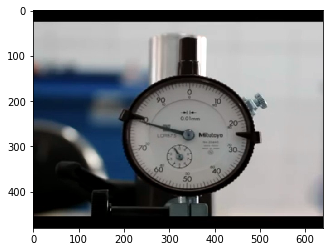

In [27]:
gauge_numberf = 400
file_typef='jpg'
# name the calibration image of your gauge 'gauge-#.jpg', for example 'gauge-5.jpg'.  It's written this way so you can easily try multiple images
min_anglef, max_anglef, min_valuef, max_valuef, unitsf, xf, yf, rf = calibrate_gauge(gauge_numberf, file_typef)
print("min_angle - %d, max_angle - %d, min_value - %d, max_value - %d, units - %s, x - %d, y - %d, r - %d" % (min_anglef, max_anglef, min_valuef, max_valuef, unitsf, xf, yf, rf))
#feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
fimg = cv2.imread('../Gauge/frames/frame%s.%s' % (gauge_numberf, file_typef))
plt.imshow(fimg)
value = get_current_value(fimg, min_anglef, max_anglef, min_valuef, max_valuef, xf, yf, rf, gauge_numberf, file_typef)
print ("Current reading: %s %s" %(value, unitsf))

In [23]:
a = np.arctan(np.divide(float(7), float(4)))

In [21]:
a

-1.0516502125483738

In [24]:
np.rad2deg(a)

60.25511870305778